# Import Lib
Neural machine translation with a Transformer and Keras - https://www.tensorflow.org/text/tutorials/transformer#the_transformer

In [1]:
#!pip install tensorflow_text

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15,8]
import seaborn as sns
import plotly.graph_objects as go

In [3]:
import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Embedding, Layer, MultiHeadAttention, LayerNormalization, Add, Dense, Dropout, Masking
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from tensorflow.math import rsqrt, minimum
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model, save_model

In [4]:
import math
import joblib

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [6]:
import warnings
warnings.filterwarnings('ignore')

# Data Preprocessing

## Import Data

In [7]:
# Mount google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
path = '/content/drive/MyDrive/MyColabProject'
data_df = pd.read_csv(path+'/raw_nsepy_length40_vocab90.csv')
data_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-11,26,23,-5,0,10,0,12,-4,5,...,16,1,4,2,17,-6,16,4,-4,-2
1,26,23,-5,0,10,0,12,-4,5,-10,...,1,4,2,17,-6,16,4,-4,-2,15
2,23,-5,0,10,0,12,-4,5,-10,0,...,4,2,17,-6,16,4,-4,-2,15,23


## Tokenizer

In [12]:
# Building Vocab
vocab = np.arange(-45,45,1)

In [13]:
vocab_size = vocab.size
vocab_size

90

In [14]:
# Creating Tokens
tokens = np.arange(0,91,1)

In [15]:
val_token_pair = {np.round(s,1):i for i,s in enumerate(vocab)}
print(val_token_pair)

{-45: 0, -44: 1, -43: 2, -42: 3, -41: 4, -40: 5, -39: 6, -38: 7, -37: 8, -36: 9, -35: 10, -34: 11, -33: 12, -32: 13, -31: 14, -30: 15, -29: 16, -28: 17, -27: 18, -26: 19, -25: 20, -24: 21, -23: 22, -22: 23, -21: 24, -20: 25, -19: 26, -18: 27, -17: 28, -16: 29, -15: 30, -14: 31, -13: 32, -12: 33, -11: 34, -10: 35, -9: 36, -8: 37, -7: 38, -6: 39, -5: 40, -4: 41, -3: 42, -2: 43, -1: 44, 0: 45, 1: 46, 2: 47, 3: 48, 4: 49, 5: 50, 6: 51, 7: 52, 8: 53, 9: 54, 10: 55, 11: 56, 12: 57, 13: 58, 14: 59, 15: 60, 16: 61, 17: 62, 18: 63, 19: 64, 20: 65, 21: 66, 22: 67, 23: 68, 24: 69, 25: 70, 26: 71, 27: 72, 28: 73, 29: 74, 30: 75, 31: 76, 32: 77, 33: 78, 34: 79, 35: 80, 36: 81, 37: 82, 38: 83, 39: 84, 40: 85, 41: 86, 42: 87, 43: 88, 44: 89}


In [16]:
# To return the token of -5
val_token_pair[-5]

40

In [17]:
val_token_pair[0]

45

In [18]:
token_val_pair = {i:np.round(s,1) for i,s in enumerate(vocab)}
print(token_val_pair)

{0: -45, 1: -44, 2: -43, 3: -42, 4: -41, 5: -40, 6: -39, 7: -38, 8: -37, 9: -36, 10: -35, 11: -34, 12: -33, 13: -32, 14: -31, 15: -30, 16: -29, 17: -28, 18: -27, 19: -26, 20: -25, 21: -24, 22: -23, 23: -22, 24: -21, 25: -20, 26: -19, 27: -18, 28: -17, 29: -16, 30: -15, 31: -14, 32: -13, 33: -12, 34: -11, 35: -10, 36: -9, 37: -8, 38: -7, 39: -6, 40: -5, 41: -4, 42: -3, 43: -2, 44: -1, 45: 0, 46: 1, 47: 2, 48: 3, 49: 4, 50: 5, 51: 6, 52: 7, 53: 8, 54: 9, 55: 10, 56: 11, 57: 12, 58: 13, 59: 14, 60: 15, 61: 16, 62: 17, 63: 18, 64: 19, 65: 20, 66: 21, 67: 22, 68: 23, 69: 24, 70: 25, 71: 26, 72: 27, 73: 28, 74: 29, 75: 30, 76: 31, 77: 32, 78: 33, 79: 34, 80: 35, 81: 36, 82: 37, 83: 38, 84: 39, 85: 40, 86: 41, 87: 42, 88: 43, 89: 44}


In [19]:
# To return the value tokenized in 436
token_val_pair[34]

-11

In [20]:
token_val_pair[0]

-45

In [21]:
data_df.max().unique()

array([43])

In [22]:
data_df.min().unique()

array([-43])

## Tokenisation

In [23]:
# Tokenize the values

#count = 0
tok_matrix = []
for i in data_df.values:
  tok_arr = []
  for j in i:
    tok_arr.append(val_token_pair[j])
  #count+=1
  #print(count)
  tok_matrix.append(tok_arr)

#print(tok_matrix)
data_df_token = pd.DataFrame(tok_matrix)

In [24]:
data_df_token

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,34,71,68,40,45,55,45,57,41,50,...,61,46,49,47,62,39,61,49,41,43
1,71,68,40,45,55,45,57,41,50,35,...,46,49,47,62,39,61,49,41,43,60
2,68,40,45,55,45,57,41,50,35,45,...,49,47,62,39,61,49,41,43,60,68
3,40,45,55,45,57,41,50,35,45,40,...,47,62,39,61,49,41,43,60,68,65
4,45,55,45,57,41,50,35,45,40,46,...,62,39,61,49,41,43,60,68,65,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72687,50,11,58,42,70,88,72,53,83,42,...,41,29,39,39,33,27,35,39,2,53
72688,11,58,42,70,88,72,53,83,42,29,...,29,39,39,33,27,35,39,2,53,53
72689,58,42,70,88,72,53,83,42,29,2,...,39,39,33,27,35,39,2,53,53,42
72690,42,70,88,72,53,83,42,29,2,2,...,39,33,27,35,39,2,53,53,42,32


## Train Test Split
* Input Length = 36
* Output Length = 4

In [25]:
inp_len = 36 # Length of the input
out_len = 4 # Length of Output and Context

In [26]:
prediction_percentage = 0.2
train_df, test_df = train_test_split(data_df_token, test_size=prediction_percentage, random_state=1, shuffle=True)

In [27]:
print('Train shape',train_df.shape)
print('Test shape',test_df.shape)

Train shape (58153, 40)
Test shape (14539, 40)


In [28]:
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=1, shuffle=True)

In [29]:
print('Train shape',train_df.shape)
print('Validation shape',val_df.shape)
print('Test shape',test_df.shape)

Train shape (43614, 40)
Validation shape (14539, 40)
Test shape (14539, 40)


Keras Model.fit training expects (inputs, labels) pairs. The inputs is tokenized sequences. The labels are the same sequences shifted by 1. This shift is so that at each location input sequence, the label in the next token.

In [30]:
train_df.columns[inp_len:].values

array([36, 37, 38, 39])

In [31]:
X_train = train_df.drop(columns=train_df.columns[inp_len:].values).values
c_train = train_df.drop(columns=train_df.columns[:inp_len].values).values
y_train = c_train
X_val = val_df.drop(columns=val_df.columns[inp_len:].values).values
c_val = val_df.drop(columns=val_df.columns[:inp_len].values).values
y_val = c_val
X_test = test_df.drop(columns=test_df.columns[inp_len:].values).values
c_test = test_df.drop(columns=test_df.columns[:inp_len].values).values
y_test = c_test

In [32]:
print('X Train shape',X_train.shape)
print('Context Train shape',c_train.shape)
print('Y Train shape',y_train.shape)
print('X Validation shape',X_val.shape)
print('Context Validation shape',c_val.shape)
print('Y Validation shape',y_val.shape)
print('X Test shape',X_test.shape)
print('Context Test shape',c_test.shape)
print('Y Test shape',y_test.shape)

X Train shape (43614, 36)
Context Train shape (43614, 4)
Y Train shape (43614, 4)
X Validation shape (14539, 36)
Context Validation shape (14539, 4)
Y Validation shape (14539, 4)
X Test shape (14539, 36)
Context Test shape (14539, 4)
Y Test shape (14539, 4)


In [33]:
X_train[0]

array([38, 75, 43, 34, 11, 43, 45, 51, 22, 49, 50, 88, 33, 62, 44, 59, 31,
       44, 69, 47, 44, 38, 25, 39, 22, 60, 54, 69, 56, 57, 37, 33, 53, 29,
       47, 48])

In [34]:
c_train[0]

array([60, 47, 52, 40])

In [35]:
y_train[0]

array([60, 47, 52, 40])

## Add Start and End Tokens
* Start token 1 <br>
* End token 89 <br>
* Padding token 0 <br>

In [ ]:
txt = list(np.arange(1,10,1))
print(txt)
txt.insert(0, 512)
print(txt)
txt.insert(-1,1023)
print(txt)
txt.extend(list(np.zeros(3,int)))
print(txt)

[1, 2, 3, 4, 5, 6, 7, 8, 9]
[512, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[512, 1, 2, 3, 4, 5, 6, 7, 8, 1023, 9]
[512, 1, 2, 3, 4, 5, 6, 7, 8, 1023, 9, 0, 0, 0]


In [36]:
def Padding(data, pad_type, inp_len, out_len):
  start_tok = 1 # Start Token
  pad_tok = 0 # Padding Token
  end_tok = 89 # End Token

  n_data = list()
  inp_len +=1
  if pad_type == 'all':
    for row in data:
      row = list(row)
      row.insert(0,start_tok)
      row.insert(inp_len,end_tok)
      n_data.append(row)
  if pad_type == 'end':
    for row in data:
      row = list(row)
      row.insert(0,start_tok)
      row.extend([pad_tok for num in range(inp_len - out_len)])
      n_data.append(row)
  if pad_type == 'padding':
    for row in data:
      row = list(row)
      row.extend([pad_tok for num in range(inp_len - out_len)])
      row.insert(inp_len,end_tok)
      n_data.append(row)
  return(np.array(n_data))

In [ ]:
#for row in X_train:
#  print(list(row))

In [37]:
X_train_pad = Padding(X_train, 'all', inp_len, out_len)
print(X_train_pad.shape)
print(X_train_pad[0])
print(X_train.shape)
print(X_train[0])

(43614, 38)
[ 1 38 75 43 34 11 43 45 51 22 49 50 88 33 62 44 59 31 44 69 47 44 38 25
 39 22 60 54 69 56 57 37 33 53 29 47 48 89]
(43614, 36)
[38 75 43 34 11 43 45 51 22 49 50 88 33 62 44 59 31 44 69 47 44 38 25 39
 22 60 54 69 56 57 37 33 53 29 47 48]


In [38]:
c_train_pad = Padding(c_train, 'end', inp_len, out_len)
print(c_train_pad.shape)
print(c_train_pad[0])
print(c_train.shape)
print(c_train[0])

(43614, 38)
[ 1 60 47 52 40  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
(43614, 4)
[60 47 52 40]


In [39]:
y_train_pad = Padding(y_train, 'padding', inp_len, out_len)
print(y_train_pad.shape)
print(y_train_pad[0])
print(y_train.shape)
print(y_train[0])

(43614, 38)
[60 47 52 40  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0 89]
(43614, 4)
[60 47 52 40]


In [40]:
X_val_pad = Padding(X_val, 'all', inp_len, out_len)
c_val_pad = Padding(c_val, 'end', inp_len, out_len)
y_val_pad = Padding(y_val, 'padding', inp_len, out_len)
X_test_pad = Padding(X_test, 'all', inp_len, out_len)
c_test_pad = Padding(c_test, 'end', inp_len, out_len)
y_test_pad = Padding(y_test, 'padding', inp_len, out_len)

In [41]:
print('X Train shape',X_train_pad.shape)
print('Context Train shape',c_train_pad.shape)
print('Y Train shape',y_train_pad.shape)
print('X Validation shape',X_val_pad.shape)
print('Context Validation shape',c_val_pad.shape)
print('Y Validation shape',y_val_pad.shape)
print('X Test shape',X_test_pad.shape)
print('Context Test shape',c_test_pad.shape)
print('Y Test shape',y_test_pad.shape)

X Train shape (43614, 38)
Context Train shape (43614, 38)
Y Train shape (43614, 38)
X Validation shape (14539, 38)
Context Validation shape (14539, 38)
Y Validation shape (14539, 38)
X Test shape (14539, 38)
Context Test shape (14539, 38)
Y Test shape (14539, 38)


In [42]:
MAX_TOKENS = vocab_size

# Model Architecture <br>
* The querys is what you're trying to find.
* The keys what sort of information the dictionary has.
* The value is that information.


## The embedding and positional encoding layer
It is common to see word embeddings that are 8-dimensional (for small datasets), up to 1024-dimensions when working with large datasets. A higher dimensional embedding can capture fine-grained relationships between words, but takes more data to learn.

In [201]:
'''
# Converting the method from numpy to tensorflow

def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  positions = tf.experimental.numpy.arange(length, dtype=tf.float32)[:, tf.newaxis]
  depths = tf.experimental.numpy.arange(depth, dtype=tf.float32)[tf.newaxis, :]

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)
'''

'\n# Converting the method from numpy to tensorflow\n\ndef positional_encoding(length, depth):\n  depth = depth/2\n\n  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)\n  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)\n\n  positions = tf.experimental.numpy.arange(length, dtype=tf.float32)[:, tf.newaxis]\n  depths = tf.experimental.numpy.arange(depth, dtype=tf.float32)[tf.newaxis, :]\n\n  angle_rates = 1 / (10000**depths)         # (1, depth)\n  angle_rads = positions * angle_rates      # (pos, depth)\n\n  pos_encoding = np.concatenate(\n      [np.sin(angle_rads), np.cos(angle_rads)],\n      axis=-1)\n\n  return tf.cast(pos_encoding, dtype=tf.float32)\n'

In [202]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = tf.experimental.numpy.arange(length, dtype=tf.float32)[:, tf.newaxis]
  depths = tf.experimental.numpy.arange(depth, dtype=tf.float32)[tf.newaxis, :]

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = tf.concat(
    [tf.math.sin(angle_rads), tf.math.cos(angle_rads)],
    axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)

In [203]:
class PositionalEmbedding(Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.vocab_size = vocab_size
    self.embedding = Embedding(vocab_size, d_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)
    self.token_embedding = Embedding(vocab_size,d_model,mask_zero=True)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def build(self, input_shape):
    # Define weights
    self.kernel = self.add_weight(
        shape=((self.vocab_size, self.d_model)),
        initializer='uniform',
        trainable=True
    )

  def call(self, x, mask=None):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

It is common to see word embeddings that are 8-dimensional (for small datasets), up to 1024-dimensions when working with large datasets. A higher dimensional embedding can capture fine-grained relationships between words, but takes more data to learn.

In [204]:
# Create an Embedding Object
embed_inp = PositionalEmbedding(vocab_size=vocab_size, d_model=8) # 8-dimensional (for small datasets)
embed_inp.build(X_train_pad[:3])
# Calling the function
inp_emb = embed_inp(X_train_pad[:3])

In [205]:
# Testing the Embedding Object Function
inp_emb[0][0]

<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([-0.12810828, -0.10067156,  0.07007629, -0.06298951,  1.0565903 ,
        1.1191971 ,  1.0745127 ,  1.0466655 ], dtype=float32)>

In [206]:
# To check if masking is enabled to the input
inp_emb._keras_mask[1]

<tf.Tensor: shape=(38,), dtype=bool, numpy=
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])>

In [207]:
# Calling the function
c_emb = embed_inp(c_train_pad[:3])
# To check if masking is enabled to the input
c_emb._keras_mask[2]

<tf.Tensor: shape=(38,), dtype=bool, numpy=
array([ True,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])>

In [208]:
# Calling the function
y_emb = embed_inp(y_train_pad[:3])
# To check if masking is enabled to the input
y_emb._keras_mask[2]

<tf.Tensor: shape=(38,), dtype=bool, numpy=
array([ True,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True])>

## Custom Attention Block

In [209]:
class BaseAttention(Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = MultiHeadAttention(**kwargs)
    self.layernorm = LayerNormalization()
    self.add = Add()
    self.mask = Masking()

In [210]:
class CrossAttention(BaseAttention):

  def build(self, input_shape):
    ## Define weights
      self.kernel = self.add_weight(
          shape=(input_shape),
          initializer='uniform',
          trainable=True)
      super(CrossAttention, self).build(input_shape)

  def call(self, key_val, query_context):
    attn_output, attn_scores = self.mha(
        query=query_context,  # The querys is what you're trying to find.
        key=key_val,  # The keys what sort of information the dictionary has.
        value=key_val, # The value is that information.
        return_attention_scores=True)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([key_val,attn_output])
    x = self.layernorm(x)

    return x

In [211]:
'''
class CrossAttention(BaseAttention):
  def call(self, x, context, mask=None):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        attention_mask=mask,
        use_causal_mask=True,
        return_attention_scores=True)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x
'''

'\nclass CrossAttention(BaseAttention):\n  def call(self, x, context, mask=None):\n    attn_output, attn_scores = self.mha(\n        query=x,\n        key=context,\n        value=context,\n        attention_mask=mask,\n        use_causal_mask=True,\n        return_attention_scores=True)\n\n    # Cache the attention scores for plotting later.\n    self.last_attn_scores = attn_scores\n\n    x = self.add([x, attn_output])\n    x = self.layernorm(x)\n\n    return x\n'

In [212]:
# Text the class
sample_ca = CrossAttention(num_heads=2, key_dim=512)

In [213]:
inp_emb._keras_mask.shape

TensorShape([3, 38])

In [214]:
inp_emb._keras_mask[:, tf.newaxis].shape

TensorShape([3, 1, 38])

In [215]:
print("input shape =",inp_emb.shape)
print("Cross attention shape =",sample_ca(key_val=inp_emb,query_context=c_emb).shape)

input shape = (3, 38, 8)
Cross attention shape = (3, 38, 8)


In [216]:
sample_ca(key_val=inp_emb,query_context=c_emb)[0][0]

<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([-1.2038285 , -1.0507771 , -0.70185244, -0.9981253 ,  0.90495443,
        0.98624384,  1.114075  ,  0.94931006], dtype=float32)>

## The global self-attention layer

In [217]:
class GlobalSelfAttention(BaseAttention):

  def build(self, input_shape):
    ## Define weights
      self.kernel = self.add_weight(
          shape=(input_shape),
          initializer='uniform',
          trainable=True)
      super(GlobalSelfAttention, self).build(input_shape)

  def call(self, key_val):
    attn_output = self.mha(
        query=key_val,  # The querys is what you're trying to find.
        key=key_val,  # The keys what sort of information the dictionary has.
        value=key_val, # The value is that information.
        )
    x = self.add([key_val, attn_output])
    x = self.layernorm(x)
    return x

In [218]:
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)

print(inp_emb.shape)
print(sample_gsa(inp_emb).shape)

(3, 38, 8)
(3, 38, 8)


In [219]:
sample_gsa(inp_emb)[0][0]

<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([-0.99043584, -1.0329468 , -0.82753295, -1.1184727 ,  0.9262919 ,
        1.1044741 ,  1.0980687 ,  0.8405531 ], dtype=float32)>

## Masked Attention Layer <br>
Causal Self Attention

Transformers are an "autoregressive" model: They generate the text one token at a time and feed that output back to the input. To make this efficient, these models ensure that the output for each sequence element only depends on the previous sequence elements; the models are "causal".<br>
The causal mask ensures that each location only has access to the locations that come before it:

In [220]:
class CausalSelfAttention(BaseAttention):

  def build(self, input_shape):
    ## Define weights
      self.kernel = self.add_weight(
          shape=(input_shape),
          initializer='uniform',
          trainable=True)
      super(CausalSelfAttention, self).build(input_shape)

  def call(self, context):
    #x = self.mask(x)
    attn_output = self.mha(
        query=self.mask(context), # The querys is what you're trying to find.
        value=self.mask(context), # The keys what sort of information the dictionary has.
        key=self.mask(context), # The value is that information.
        use_causal_mask = True) # causal_mask is used to appropriately mask when computing the attention scores

    #x = self.mask(x)
    context = self.add([context, attn_output])
    #x = self.mask(x)
    context = self.layernorm(context)
    return context

In [221]:
sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)

print(c_emb.shape)
print(sample_csa(c_emb).shape)

(3, 38, 8)
(3, 38, 8)


In [222]:
sample_csa(c_emb)[0][0:5]

<tf.Tensor: shape=(5, 8), dtype=float32, numpy=
array([[-0.9262692 , -1.198699  , -0.8209932 , -1.0031344 ,  1.1907387 ,
         0.879221  ,  0.79162306,  1.0875127 ],
       [ 0.75995135, -1.3669771 , -1.246707  , -1.1590563 ,  0.39987898,
         0.6818757 ,  0.70238936,  1.2286457 ],
       [ 1.0463696 , -0.7325677 , -0.53072774, -0.9767213 , -1.5623724 ,
         0.85928196,  0.69716626,  1.1995714 ],
       [ 0.07806185, -0.68303573, -0.47100952, -0.6174462 , -1.7296077 ,
         1.2083172 ,  1.0823916 ,  1.1323282 ],
       [-1.1887703 , -0.49891403, -0.42902803, -0.31525522, -1.199675  ,
         1.3014631 ,  0.8572514 ,  1.472928  ]], dtype=float32)>

In [223]:
#out1 = sample_csa(embed_inp(X_train_pad[:, :3]))
#out2 = sample_csa(embed_inp(X_train_pad))[:, :3]

#tf.reduce_max(abs(out1 - out2)).numpy()

## Feed Forward Network Layer

In [224]:
class FeedForward(Layer):
  # dff - dence feed forward neurons
  # d_model - input shape
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = Sequential([
      Dense(dff, activation='relu'),
      Dense(d_model),
      Dropout(dropout_rate)
    ])
    self.add = Add()
    self.layer_norm = LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x

In [225]:
sample_ffn = FeedForward(8, 512)

print(inp_emb.shape)
print(sample_ffn(inp_emb).shape)

(3, 38, 8)
(3, 38, 8)


In [226]:
sample_ffn(inp_emb)[0][0]

<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([-1.189972  , -1.1579292 , -0.7357965 , -0.8092581 ,  0.8746402 ,
        0.70331454,  1.3583039 ,  0.9566966 ], dtype=float32)>

## Complete Encoder Layer

In [227]:
class EncoderLayer(Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, key_val):
    x = self.self_attention(key_val)
    x = self.ffn(x)
    return x

In [228]:
class Encoder(Layer):
  def __init__(self,*, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
      for _ in range(num_layers)]

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.dropout = Dropout(dropout_rate)

  def call(self, key_val):
    # `x` is token-IDs
    x = self.pos_embedding(key_val)
    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x

In [229]:
# Testing the encoder

# Instantiate the encoder.
sample_encoder = Encoder(num_layers=4,
                         d_model=8,
                         num_heads=8,
                         dff=512,
                         vocab_size=vocab_size)

In [230]:
sample_encoder_output = sample_encoder(X_train_pad[:3], training=False)
# Print the shape.
print(X_train_pad[:3].shape)
print(sample_encoder_output.shape)

(3, 38)
(3, 38, 8)


In [231]:
sample_encoder(X_train_pad[:3], training=False)[0][0]

<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([ 0.33135206, -1.3745401 , -1.1092733 , -1.242528  ,  1.028667  ,
        0.34968507,  0.9663021 ,  1.0503352 ], dtype=float32)>

## Complete Decoder Layer

Each DecoderLayer containing a CausalSelfAttention, a CrossAttention, and a FeedForward layer:

In [232]:
class DecoderLayer(Layer):
  def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_att = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate
    )

    self.cross_att = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate
    )

    self.ffn = FeedForward(d_model, dff)

  def call(self, key_val, query_context):
    self_att_out = self.causal_self_att(context=query_context)
    cross_att_out = self.cross_att(key_val=key_val, query_context=self_att_out)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_att.last_attn_scores

    fnn_out = self.ffn(cross_att_out)

    return fnn_out


In [233]:
# Testing decoder layer

sample_decoder_layer = DecoderLayer(d_model=8, num_heads=8, dff=512)

sample_decoder_layer_output = sample_decoder_layer(
    key_val=inp_emb, query_context=c_emb)

In [234]:
sample_decoder_layer_output[0][0]

<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([-1.3364179 , -1.0277967 , -0.4332603 , -1.0342349 ,  0.8730559 ,
        0.85438097,  1.3552226 ,  0.7490505 ], dtype=float32)>

In [235]:
print(inp_emb.shape)
print(sample_decoder_layer_output.shape)

(3, 38, 8)
(3, 38, 8)


In [236]:
class Decoder(Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.decoder_layer = [DecoderLayer(
      d_model=d_model,
      num_heads=num_heads,
      dff=dff,
      dropout_rate=dropout_rate
    ) for _ in range(num_layers)]

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)

    self.dropout = Dropout(rate=dropout_rate)

    self.last_attn_scores = None

    self.d_model = d_model
    self.num_layers = num_layers

  def call(self, key_val, query_context):
    query_context = self.pos_embedding(query_context)

    query_context = self.dropout(query_context)

    for i in range(self.num_layers):
      x  = self.decoder_layer[i](key_val=key_val, query_context=query_context)

    self.last_attn_scores = self.decoder_layer[-1].last_attn_scores

    return x

In [237]:
# Test the decoder

# Instantiate the decoder.
sample_decoder = Decoder(num_layers=4,
                         d_model=8,
                         num_heads=8,
                         dff=512,
                         vocab_size=vocab_size)

output = sample_decoder(
    key_val=inp_emb,
    query_context=c_train_pad[:3])

In [238]:
output[0][0]

<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([-0.4469414 , -1.3146024 , -0.80438435, -1.2611789 ,  1.1797619 ,
        1.0225042 ,  0.99934477,  0.6254959 ], dtype=float32)>

In [239]:
print(c_train_pad[:3].shape)
print(inp_emb.shape)
print(output.shape)

(3, 38)
(3, 38, 8)
(3, 38, 8)


## Transformer

In [240]:
class Transformer(Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = Dense(target_vocab_size)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    key_val, query_context  = inputs

    enc_out = self.encoder(key_val=key_val)  # (batch_size, context_len, d_model)

    dec_out = self.decoder(key_val=enc_out, query_context=query_context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(dec_out)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

## Custom Learning Rate

In [266]:
class CustomSchedule(LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return rsqrt(self.d_model) * minimum(arg1, arg2)

In [267]:
sample_learning_rate = CustomSchedule(8)

sample_optimizer = Adam(sample_learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-8)

Text(0.5, 0, 'Train Step')

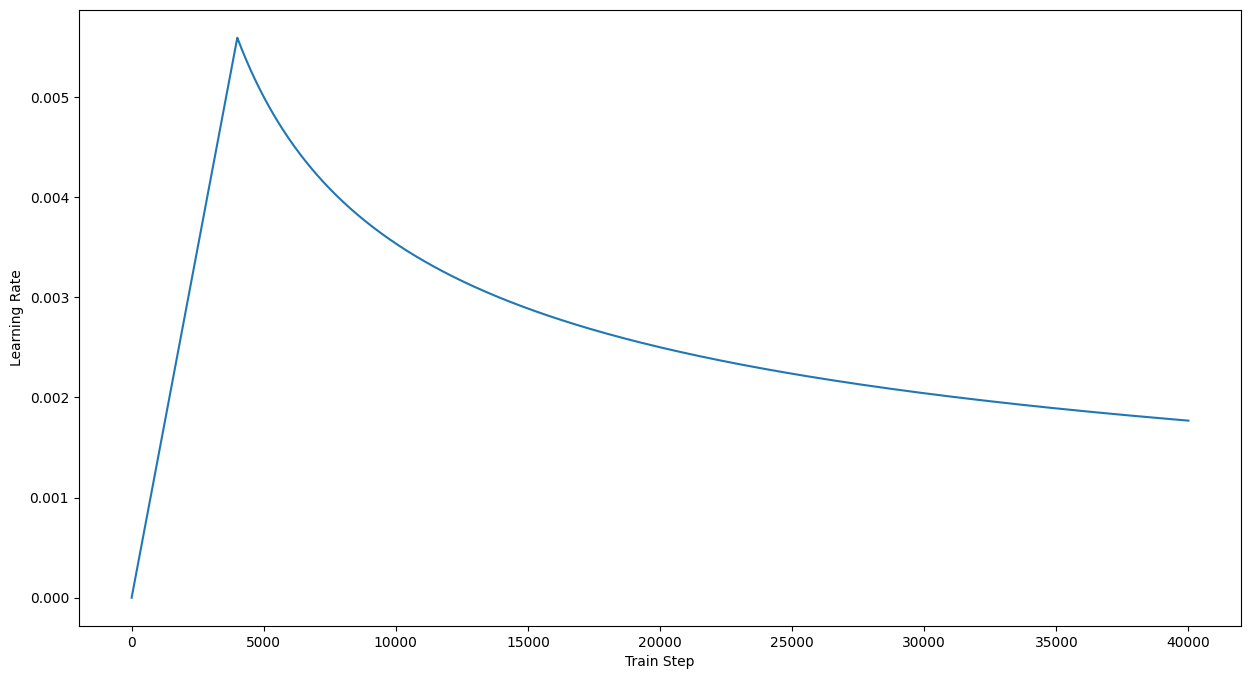

In [268]:
# Check the learning Rate
plt.plot(sample_learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

## Set up the loss and metrics

In [269]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = SparseCategoricalCrossentropy(from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

# Model 1

## Model building

In [270]:
#Define a model with Transformer layer
tf.keras.backend.clear_session()
#model = tf.keras.Sequential()

In [271]:
num_layers = 6 # number of TransformerEncoderLayer layers (Original paper = 6)
d_model = 16 # dimensionality of the embeddings (Original paper = 512)
dff = 4  # dimensionality of the feed-forward network hidden layer (Original paper = 2048)
num_heads = 8 # number of self-attention heads in the MultiheadAttention layer (Original paper = 8)
dropout_rate = 0.2

In [272]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=vocab_size,
    target_vocab_size=vocab_size,
    dropout_rate=dropout_rate)

In [273]:
output = transformer((X_train_pad[:3], c_train_pad[:3]))

print(X_train_pad[:3].shape)
print(output.shape)

(3, 38)
(3, 38, 90)


In [274]:
attn_scores = transformer.decoder.decoder_layer[-1].last_attn_scores
print(attn_scores.shape)

(3, 8, 38, 38)


In [275]:
transformer.summary()

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder (Encoder)                    │ ?                           │          66,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Decoder)                    │ ?                           │         129,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (3, 38, 90)                 │           1,530 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 197,514 (771.54 KB)

 Trainable params: 197,514 (771.54 KB)

 Non-trainable params: 0 (0.00 B)

## Training

In [276]:
learning_rate = CustomSchedule((d_model))
optimizer = Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-8)

In [277]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [278]:
path_model = '/content/drive/MyDrive/MyColabProject'
checkpoint_filepath = (path_model+'/4SF_nsepy_Model_in36_out2_vocab90.weights.h5')
print(checkpoint_filepath)

/content/drive/MyDrive/MyColabProject/4SF_nsepy_Model_in36_out2_vocab90.weights.h5


In [279]:
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

early_stopping = EarlyStopping(monitor="val_loss",
                               patience=10, mode="min",
                               restore_best_weights=True)

In [280]:
transformer.fit((X_train_pad,c_train_pad),y_train_pad,
                epochs=5, batch_size=32,
                validation_data=[(X_val_pad,c_val_pad),y_val_pad],
                callbacks=[model_checkpoint_callback, early_stopping])

Epoch 1/5
1363/1363 ━━━━━━━━━━━━━━━━━━━━ 381s 233ms/step - loss: 3.6027 - masked_accuracy: 0.2077 - val_loss: 2.6940 - val_masked_accuracy: 0.2710
Epoch 2/5
1363/1363 ━━━━━━━━━━━━━━━━━━━━ 298s 218ms/step - loss: 2.6816 - masked_accuracy: 0.2708 - val_loss: 2.6852 - val_masked_accuracy: 0.2701
Epoch 3/5
1363/1363 ━━━━━━━━━━━━━━━━━━━━ 329s 224ms/step - loss: 2.6746 - masked_accuracy: 0.2703 - val_loss: 2.6791 - val_masked_accuracy: 0.2715
Epoch 4/5
1363/1363 ━━━━━━━━━━━━━━━━━━━━ 301s 221ms/step - loss: 2.6754 - masked_accuracy: 0.2712 - val_loss: 2.6753 - val_masked_accuracy: 0.2718
Epoch 5/5
1363/1363 ━━━━━━━━━━━━━━━━━━━━ 332s 229ms/step - loss: 2.6728 - masked_accuracy: 0.2716 - val_loss: 2.6759 - val_masked_accuracy: 0.2711


In [281]:
transformer.fit((X_train_pad,c_train_pad),y_train_pad,
                initial_epoch=5,epochs=25, batch_size=32,
                validation_data=[(X_val_pad,c_val_pad),y_val_pad],
                callbacks=[model_checkpoint_callback, early_stopping])

Epoch 6/25
1363/1363 ━━━━━━━━━━━━━━━━━━━━ 307s 225ms/step - loss: 2.6662 - masked_accuracy: 0.2727 - val_loss: 2.6788 - val_masked_accuracy: 0.2663
Epoch 7/25
1363/1363 ━━━━━━━━━━━━━━━━━━━━ 297s 218ms/step - loss: 2.6676 - masked_accuracy: 0.2724 - val_loss: 2.6737 - val_masked_accuracy: 0.2724
Epoch 8/25
1363/1363 ━━━━━━━━━━━━━━━━━━━━ 322s 218ms/step - loss: 2.6625 - masked_accuracy: 0.2710 - val_loss: 2.6719 - val_masked_accuracy: 0.2718
Epoch 9/25
1363/1363 ━━━━━━━━━━━━━━━━━━━━ 325s 220ms/step - loss: 2.6643 - masked_accuracy: 0.2714 - val_loss: 2.6710 - val_masked_accuracy: 0.2718
Epoch 10/25
1363/1363 ━━━━━━━━━━━━━━━━━━━━ 324s 222ms/step - loss: 2.6590 - masked_accuracy: 0.2728 - val_loss: 2.6708 - val_masked_accuracy: 0.2717
Epoch 11/25
1363/1363 ━━━━━━━━━━━━━━━━━━━━ 317s 218ms/step - loss: 2.6593 - masked_accuracy: 0.2722 - val_loss: 2.6710 - val_masked_accuracy: 0.2716
Epoch 12/25
1363/1363 ━━━━━━━━━━━━━━━━━━━━ 322s 218ms/step - loss: 2.6554 - masked_accuracy: 0.2731 - val_loss

In [289]:
transformer.fit((X_train_pad,c_train_pad),y_train_pad,
                initial_epoch=25,epochs=50, batch_size=32,
                validation_data=[(X_val_pad,c_val_pad),y_val_pad],
                callbacks=[model_checkpoint_callback, early_stopping])

Epoch 26/50
1363/1363 ━━━━━━━━━━━━━━━━━━━━ 292s 215ms/step - loss: 2.6515 - masked_accuracy: 0.2732 - val_loss: 2.6717 - val_masked_accuracy: 0.2713
Epoch 27/50
1363/1363 ━━━━━━━━━━━━━━━━━━━━ 323s 215ms/step - loss: 2.6589 - masked_accuracy: 0.2722 - val_loss: 2.6686 - val_masked_accuracy: 0.2717
Epoch 28/50
1363/1363 ━━━━━━━━━━━━━━━━━━━━ 332s 223ms/step - loss: 2.6554 - masked_accuracy: 0.2725 - val_loss: 2.6678 - val_masked_accuracy: 0.2715
Epoch 29/50
1363/1363 ━━━━━━━━━━━━━━━━━━━━ 345s 240ms/step - loss: 2.6503 - masked_accuracy: 0.2741 - val_loss: 2.6736 - val_masked_accuracy: 0.2718
Epoch 30/50
1363/1363 ━━━━━━━━━━━━━━━━━━━━ 354s 220ms/step - loss: 2.6493 - masked_accuracy: 0.2735 - val_loss: 2.6680 - val_masked_accuracy: 0.2723
Epoch 31/50
1363/1363 ━━━━━━━━━━━━━━━━━━━━ 285s 209ms/step - loss: 2.6560 - masked_accuracy: 0.2730 - val_loss: 2.6681 - val_masked_accuracy: 0.2714
Epoch 32/50
1363/1363 ━━━━━━━━━━━━━━━━━━━━ 328s 213ms/step - loss: 2.6529 - masked_accuracy: 0.2732 - val_

KeyboardInterrupt: 

## Prediction - from Transformer

In [290]:
predictions = transformer((X_test_pad[:1000],c_test_pad[:1000]), training=False)
#predictions = transformer((X_test_pad,c_test_pad), training=False)

In [291]:
predictions.shape

TensorShape([1000, 38, 90])

In [292]:
predictions[0]

<tf.Tensor: shape=(38, 90), dtype=float32, numpy=
array([[-19.37155  , -19.628214 ,  -3.3364968, ...,  -7.791993 ,
         -4.5062137,  -9.279521 ],
       [-20.585499 , -20.816805 ,  -3.3938107, ...,  -8.019295 ,
         -4.3681808,  -9.869928 ],
       [-20.179531 , -20.400309 ,  -3.4638271, ...,  -8.079339 ,
         -4.555264 ,  -9.72219  ],
       ...,
       [ -7.079898 ,  -6.8482256,  -2.766844 , ...,   3.8588526,
         -2.1331596,  20.928944 ],
       [ -6.9215374,  -6.7022076,  -2.8009348, ...,   3.9064558,
         -2.1740227,  21.09655  ],
       [ -6.308255 ,  -6.1614084,  -2.9458017, ...,   4.055416 ,
         -2.5322442,  22.115412 ]], dtype=float32)>

In [293]:
predictions_val = np.argmax(predictions, axis=2)
predictions_val.shape

(1000, 38)

In [294]:
i = 765
print('Predictions = \n',predictions_val[i])
print('Actuals = \n',y_test_pad[i])

Predictions = 
 [50 43 88 88 50 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89
 89 89 89 89 89 89 89 89 89 89 89 89 89 89]
Actuals = 
 [58 88 61 43  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0 89]


### Validating the results

In [295]:
y_pred_1 = predictions_val[:,0]
y_pred_2 = predictions_val[:,1]
y_pred_3 = predictions_val[:,2]
y_pred_4 = predictions_val[:,3]
y_test_small = y_test[:1000]
y_test_1 = y_test[:,0]
y_test_2 = y_test[:,1]
y_test_3 = y_test[:,2]
y_test_4 = y_test[:,3]
print(y_pred_1.shape)
print(y_test_1.shape)
#print(y_test[:1000,1].shape)

(1000,)
(14539,)


In [296]:
accuracy = accuracy_score(y_test[:1000,1], y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.10


In [297]:
accuracy_1 = accuracy_score(y_test_1[:1000], y_pred_1)
accuracy_2 = accuracy_score(y_test_2[:1000], y_pred_2)
accuracy_3 = accuracy_score(y_test_3[:1000], y_pred_3)
accuracy_4 = accuracy_score(y_test_4[:1000], y_pred_4)
print(f"Accuracy 1: {accuracy_1:.2f}")
print(f"Accuracy 2: {accuracy_2:.2f}")
print(f"Accuracy 3: {accuracy_3:.2f}")
print(f"Accuracy 4: {accuracy_4:.2f}")

Accuracy 1: 0.07
Accuracy 2: 0.09
Accuracy 3: 0.10
Accuracy 4: 0.08


In [298]:
fig = go.Figure(data=[go.Ohlc(x=np.arange(0,1000,1),
                    open=y_pred_4,
                    high=y_pred_4,
                    low=y_test_4[:1000],
                    close=y_test_4[:1000]
                              )])
fig.show()

In [ ]:
'''
fig = go.Figure(data=[go.Ohlc(x=np.arange(0,1000,1),
                    open=y_pred,
                    high=y_pred,
                    low=y_test,
                    close=y_test
                              )])
fig.show()
'''

## Prediction - from Saved model

In [ ]:
# Save the model - not required - using different save method

#model_path = '/content/drive/MyDrive/hobby_project/Models/forecaster_future1_pred_finetune/'
#tf.saved_model.save(osf_tf_function, export_dir=model_path)

In [ ]:
# Load the model
#model_path = '/content/drive/MyDrive/hobby_project/Models/forecaster_future1_pred_finetune/'
#pre_trained_forecaster = tf.saved_model.load(model_path)

In [ ]:
path_model = '/content/drive/MyDrive/hobby_project/Models'
checkpoint_filepath = (path_model+'/8SF_Model_inp32_vocab16_BKP17sep.weights.h5')
print(checkpoint_filepath)

/content/drive/MyDrive/hobby_project/Models/8SF_Model_inp32_vocab16_BKP17sep.weights.h5


In [ ]:
transformer.load_weights(checkpoint_filepath)

### Prediction from Pre-trained loaded transformer

In [ ]:
predictions_reconstructed_model = transformer((X_test_pad,c_test_pad), training=False)

In [ ]:
predictions_val_reconstructed_model = np.argmax(predictions_reconstructed_model, axis=2)
predictions_val_reconstructed_model.shape

(2523, 34)

In [ ]:
i = 1
print('Predictions = \n',predictions_val_reconstructed_model[i])
print('Actuals = \n',y_test_pad[i])

Predictions = 
 [   1  509  509  509  509  509  509  509  509  509  509  509  509  509
  509  509  509  509  509  509  509  509  509  509  509  509  509  509
  509  509  509  509  509 1023]
Actuals = 
 [   1  509    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0 1023]


### Compare saved model with Actuals

In [ ]:
y_reconstructed_model = predictions_val_reconstructed_model[:,1]

In [ ]:
y_reconstructed_model

array([542, 509, 588, ..., 542, 523, 514])

In [ ]:
print(y_reconstructed_model.shape)
print(y_test.shape)

accuracy = accuracy_score(y_test,y_reconstructed_model)
print(f"Accuracy: {accuracy:.2f}")

(2523,)
(2523,)
Accuracy: 0.85


In [ ]:
fig = go.Figure(data=[go.Ohlc(x=np.arange(0,1000,1),
                    open=y_reconstructed_model,
                    high=y_reconstructed_model,
                    low=y_test,
                    close=y_test
                              )])
fig.show()

### Exporting the outputs to csv

In [ ]:
data_df = pd.read_csv(path+'/OSF_results.csv')
data_df.columns

Index(['Actuals', 'OSF_Model_1', 'OSF_2'], dtype='object')

In [ ]:
# Uncomment only if you wish to compare the data in excel sheet
data_df = pd.read_csv(path+'/OSF_results.csv')
#data_df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

# Using DataFrame.insert() to add a column
#data_df.insert(2, "OSF_2", y_reconstructed_model, True)
data_df.insert(2, "OSF_2_better", y_pred, True)

data_df

,Actuals,OSF_Model_1,OSF_2_better,OSF_2
0,542,542,542,542
1,509,509,509,509
2,722,562,586,588
3,517,517,517,517
4,525,525,525,525
...,...,...,...,...
2518,520,520,520,520
2519,500,500,500,500
2520,542,542,542,542
2521,523,523,523,523


In [ ]:
data_df.to_csv(path+'/OSF_results.csv',index=False)

# Failed Models

In [ ]:
# Model 2
# Inputs
'''
num_layers = 6 # number of TransformerEncoderLayer layers (Original paper = 6)
d_model = 12 # dimensionality of the embeddings (Original paper = 512)
dff = 32  # dimensionality of the feed-forward network hidden layer (Original paper = 2048)
num_heads = 8 # number of self-attention heads in the MultiheadAttention layer (Original paper = 8)
dropout_rate = 0.2
'''
# Weights = 129K Parameters

# Learning Rate = d_model**2

# Output
'''
Train Accuracy = 0.28
Val Accuracy = 0.27
Test Accuracy = 0.10

In [ ]:
# Model 3 - UNDER DEVELOPMENT
# Inputs
'''
num_layers = 6 # number of TransformerEncoderLayer layers (Original paper = 6)
d_model = 16 # dimensionality of the embeddings (Original paper = 512)
dff = 4  # dimensionality of the feed-forward network hidden layer (Original paper = 2048)
num_heads = 8 # number of self-attention heads in the MultiheadAttention layer (Original paper = 8)
dropout_rate = 0.2
'''
# Weights = 197K Parameters

# Learning Rate = d_model

# Output
'''
Train Accuracy = 0.27
Val Accuracy = 0.27
Test Accuracy = 0.10

# Success Models

In [ ]:
# Model 1 - 1st Best model
# Inputs
'''
num_layers = 6 # number of TransformerEncoderLayer layers (Original paper = 6)
d_model = 16 # dimensionality of the embeddings (Original paper = 512)
dff = 32  # dimensionality of the feed-forward network hidden layer (Original paper = 2048)
num_heads = 6 # number of self-attention heads in the MultiheadAttention layer (Original paper = 8)
dropout_rate = 0.2
'''
# Weights = 170K Parameters

# Learning Rate = d_model**2

# Output
'''
Train Accuracy = 0.28
Val Accuracy = 0.27
Test Accuracy = 0.10